協調フィルタリング(Collaborative Filtering)の各手法を比較する。
- メモリベース
- モデルベース
- 深層学習

MovieLensで検証する。

In [2]:
import pandas as pd
import urllib.request
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# MovieLens100kをダウンロードして解凍
urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-25m.zip', '../data/ml-25m.zip')
with zipfile.ZipFile('../data/ml-25m.zip') as zip_file:
    zip_file.extractall('../data/')

In [3]:
from functools import wraps
import time
def stop_watch(func) :
    """
    Note
    https://qiita.com/hisatoshi/items/7354c76a4412dffc4fd7
    """
    @wraps(func)
    def wrapper(*args, **kargs) :
        start = time.time()
        result = func(*args,**kargs)
        elapsed_time =  time.time() - start
        print(f"{func.__name__}は{elapsed_time}秒かかりました")
        return result
    return wrapper

In [4]:
import random
random.seed(0)

def filter_df(ratings: pd.DataFrame, col_name: str, N: int):
    """
    指定したカラムを指定しサンプル数になるようにDataFrameを絞り込む
    """
    factor_list = list(set(ratings[col_name]))
    factor_sample = random.sample(factor_list, N)
    return ratings.query(f'{col_name} in @factor_sample').reset_index(drop=True)

In [5]:
def describe_result(recommend: list, movies: pd.DataFrame):
    """
    レコメンド結果に映画の属性情報を付与する
    """
    recommend_tmp = pd.DataFrame(recommend, columns=('movieId', 'estimated_rating'))
    recommend_tmp.loc[:, 'movieId'] = recommend_tmp.movieId.astype('str')
    movies.loc[:, 'movieId'] = movies.movieId.astype('str')
    result = pd.merge(
        recommend_tmp,
        movies,
        on=['movieId'],
        how='left'
    )
    return result

In [6]:
def describe_user(ratings: pd.DataFrame, movies: pd.DataFrame):
    """
    ユーザの過去評価実績に映画の属性情報を付与する
    """
    ratings.loc[:, 'movieId'] = ratings.movieId.astype('str')
    movies.loc[:, 'movieId'] = movies.movieId.astype('str')
    result = pd.merge(
        ratings,
        movies,
        on=['movieId'],
        how='left'
    )
    return result

In [7]:
def add_onehot_genres(movies: pd.DataFrame):
    """
    genresカラムをOneHot表現に変換する
    """
    # genresカラムの文字列を'|'でlistに分割
    genres_col = movies.genres.map(lambda x: x.split('|')).to_list()
    # OneHot表現するgenresの要素のlist作成
    genre_col_name = list()
    for i in genres_col:
        genre_col_name.extend(i)
    genre_col_name = list(set(genre_col_name))
    # OneHot表現作成
    # 処理の高速化のために各行をlist化し、最後にDataFrameを作成
    rows = list()
    for index, row in enumerate(genres_col):
        row_list = np.array([0] * len(genre_col_name))
        index_list = [genre_col_name.index(item) for item in row]
        row_list[index_list] = 1
        rows.append(list(row_list))
    genre_df = pd.DataFrame(rows, columns=genre_col_name)
    return (pd.concat([movies, genre_df], axis=1), genre_col_name)

In [99]:
ratings = pd.read_csv('../data/ml-25m/ratings.csv')
print(f'ユーザー数: {len(set(ratings.userId))}')

ユーザー数: 162541


In [100]:
movies = pd.read_csv('../data/ml-25m/movies.csv')
print(f'映画数: {len(set(movies.movieId))}')

映画数: 62423


In [101]:
# IDを文字列に変換
ratings.loc[:, 'userId'] = ratings.userId.astype('str')
ratings.loc[:, 'movieId'] = ratings.movieId.astype('str')

In [109]:
movies.loc[:, 'movieId'] = movies.movieId.astype('str')

In [102]:
# 計算コストを抑えるためにユーザー数を絞る
ratings_sample = filter_df(ratings, col_name='userId', N=1000)

In [103]:
# 学習データ、テストデータに分割
# https://stackoverflow.com/questions/42395258/split-dataset-per-user-according-to-timestamp-in-training-and-test-set-in-python
ranks = ratings_sample.groupby('userId')['timestamp'].rank(method='first')
counts = ratings_sample['userId'].map(ratings_sample.groupby('userId')['timestamp'].apply(len))
train = ratings_sample[~((ranks / counts) > 0.8)]
test = ratings_sample[(ranks / counts) > 0.8]

In [12]:
# 検証対象のuserId
sampling_user_id = random.sample(list(set(train.userId)), 3)

In [93]:
def plot_sampling_user_dist(sampling_user_id, ratings, movies):
    """
    ユーザーの分布を可視化
    """
    ratings = describe_user(ratings, movies)
    ratings, genre_col_name = add_onehot_genres(ratings)
    plt.figure(figsize=(24,7))
    for num, user_id in enumerate(sampling_user_id):
        ratings_tmp = ratings.query(f'userId == {user_id}')
        cnt_by_genre = [(i, np.sum(ratings_tmp[i])) for i in genre_col_name]
        cnt_by_genre_df = pd.DataFrame(cnt_by_genre, columns=('genres', 'cnt'))
        plt.subplot(1,3,num+1)
        sns.barplot(x='cnt', y='genres', data=cnt_by_genre_df)
        plt.title(f'genres rated by userId:{user_id}')
    return genre_col_name

In [91]:
def plot_recommend_dist(sampling_user_id, movies, model, topN, genre_col_name):
    """
    レコメンド結果を可視化
    """
    plt.figure(figsize=(24,7))
    for num, user_id in enumerate(sampling_user_id):
        tmp = describe_result(model.recommend(user_id, topN), movies)
        tmp, _ = add_onehot_genres(tmp)
        cnt_by_genre = [(i, np.sum(tmp[i])) if i in tmp.columns else (i, 0) for i in genre_col_name]
        cnt_by_genre_df = pd.DataFrame(cnt_by_genre, columns=('genres', 'cnt'))
        plt.subplot(1,3,num+1)
        sns.barplot(x='cnt', y='genres', data=cnt_by_genre_df)
        plt.title(f'recommend genres to userId:{user_id}')

In [92]:
# https://yolo-kiyoshi.com/2019/12/03/post-1557/
def precision_k(actual:list, predicted:list, k:int=10) -> float:
    """
    Precision@Kを測定するメソッド

    Parameters
    ----------
    actual : list
        実際にユーザが嗜好したアイテムのlist
    predicted : list
        レコメンドしたアイテムのlist
    k : int
        測定対象のアイテムtopN
    
    Returns
    ----------
    precision_k_value : float
        Precision@K
    """
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    
    precision_k_value = len(actual_set & predicted_set)/k
    
    return precision_k_value


def recall_k(actual:list, predicted:list, k:int=10) -> float:
    """
    Recall@Kを測定するメソッド

    Parameters
    ----------
    actual : list
        実際にユーザが嗜好したアイテムのlist
    predicted : list
        レコメンドしたアイテムのlist
    k : int
        測定対象のアイテムtopN
    
    Returns
    ----------
    recall_k_value : float
        Recall@K
    """
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    
    recall_k_value = len(actual_set & predicted_set)/len(actual)
    
    return recall_k_value


def ap_k(actual:list, predicted:list, k:int=10) -> float:
    """
    AP@Kを測定するメソッド

    Parameters
    ----------
    actual : list
        実際にユーザが嗜好したアイテムのlist
    predicted : list
        レコメンドしたアイテムのlist
    k : int
        測定対象のアイテムtopN
    
    Returns
    ----------
    ap_k_value : float
        AP@K
    """
    ap_k_list = []
    for i in range(k):
        if len(actual) > i:
            ap_k_list.append(precision_k(actual, predicted, i+1))
    
    ap_k_value = sum(ap_k_list)/min(len(actual), k)
    
    return ap_k_value


def map_k(actuals:list, predicteds:list, k:int=10) -> list:
    """
    MAP@Kを測定するメソッド

    Parameters
    ----------
    actuals : list
        実際にユーザが嗜好したアイテムのlistのlist
    predicteds : list
        レコメンドしたアイテムのlistのlist
    k : int
        測定対象のアイテムtopN
    
    Returns
    ----------
    map_k_list : list
        MAP@K
    """
    map_k_list = []
    for i in range(k):
        ap_k_list = []
        for actual, predicted in zip(actuals, predicteds):
            ap_k_list.append(
                ap_k(actual, predicted, i+1)
            )
        map_k_list.append(
            sum(ap_k_list)/len(actuals)
        )
    
    return map_k_list

# Content-Base Filtering

映画の属性情報をもとに特徴量を生成する。今回はジャンル名を使用する。

In [177]:
movies = filter_df(movies, col_name='movieId', N=1000)

In [181]:
movies, genre_col_name = add_onehot_genres(movies)

In [277]:
class ContentBaseFiltering:
    """
    content-base filteringを実装したクラス
    """
    def __init__(self, data, item_id_name: str, feature_col_names: list):
        
        def get_itemId2index(item_id_series: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(item_id_series):
                itemId2index[item_id] = num
            return itemId2index
        
        self.data = data
        self.item_id_name = item_id_name
        self.feature_col_names = feature_col_names
        self.itemId2index = get_itemId2index(data[item_id_name])
        
    
    def fit(self):
        c = np.array(self.data[self.feature_col_names])
        norm = np.matrix(np.linalg.norm(c, axis=1))
        np.dot(norm.T, norm)
        # 類似度行列
        self.sim_mat = np.array(np.dot(c, c.T)/np.dot(norm.T, norm))
    
    
    def recommend(self, item_id, topN: int):
        # 類似度行列で対象アイテムの行数を取得
        row_num = self.itemId2index[item_id]
        topN_index = np.argsort(self.sim_mat[row_num])[::-1][2:topN]
        sims = self.sim_mat[row_num][topN_index]
        item_id_list = self.data[self.item_id_name][topN_index]
        return [(item, sim) for item, sim in zip(item_id_list, sims)]
        

In [278]:
cbf = ContentBaseFiltering(
    data=movies, item_id_name='movieId', feature_col_names=genre_col_name)

In [279]:
cbf.fit()

In [280]:
cbf.recommend(item_id=378, topN=10)

[(51082, 0.9999999999999998),
 (54004, 0.9999999999999998),
 (169868, 0.9999999999999998),
 (177475, 0.9999999999999998),
 (79775, 0.9999999999999998),
 (88925, 0.9999999999999998),
 (179553, 0.9999999999999998),
 (205106, 0.9999999999999998)]

# Memory-base CF

In [110]:
class MemoryBaseCF:
    
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str):
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        self.data = data
    
    
    def get_index2itemId(self, item_id_list: list):
            index2itemId = dict()
            for num, item_id in enumerate(item_id_list):
                index2itemId[num] = item_id
            return index2itemId
    
    
    def get_userId2index(self, user_id_list: list):
        userId2index = dict()
        for num, user_id in enumerate(user_id_list):
            userId2index[user_id] = num
        return userId2index
    
    
    def fit(self):
        
        def get_similarity_matrix(ratings_pivod: pd.DataFrame):
            """
            類似度行列を作成する
            """
            ratings_array = np.array(ratings_pivod)

            size = ratings_array.shape[0]
            # 類似度行列を初期化
            sim = np.zeros((size, size))
            # 類似度行列の上三角行列を作成
            for i in range(size):
                for j in range(i, size):
                    # 評価されているindexのみを取得
                    co_eval_index = list(
                        set(np.where(~np.isnan(ratings_array[i]))[0])
                        & set(np.where(~np.isnan(ratings_array[j]))[0])
                    )
                    a = ratings_array[i][co_eval_index]
                    b = ratings_array[j][co_eval_index]
                    sim[i, j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

            # 上三角行列 + 下三角行列
            sim_mat = sim + sim.T - np.identity(size)
            # nanを0で埋める
            sim_mat = np.nan_to_num(sim_mat)
            return sim_mat
        
        self.sim_mat = get_similarity_matrix(self.data)

## User-base collaborative filtering

In [111]:
class UserBaseCF(MemoryBaseCF):
    """
    user-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str):
        
        super(UserBaseCF, self).__init__(data, user_id_name, item_id_name, rating_name)
        # item_idを縦持ちから横持ちに変換
        ratings_pivod = data.pivot_table(values=[rating_name], index=[user_id_name], columns=[item_id_name], aggfunc='sum')
        # MultiIndexを解除、item_inの特徴量カラムに変更
        item_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = item_columns
        ratings_pivod = ratings_pivod.reset_index()
        
        self.data = ratings_pivod[item_columns]
        self.index2itemId = self.get_index2itemId(item_columns)
        self.userId2index = self.get_userId2index(ratings_pivod[user_id_name])

    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        user_index = self.userId2index[user_id]
        # 類似度行列作成
        ratings_array = np.array(self.data)
        # 未評価のindex
        non_eval_index_list = np.where(np.isnan(ratings_array[user_index]))[0]

        est_eval = list()
        for index in non_eval_index_list:
            # 未評価のindexを評価しているuserのindex
            eval_user_index = np.where(~np.isnan(ratings_array[:, index]))
            # 未評価のindexに対する評価を推定
            k = np.nansum(self.sim_mat[user_index][eval_user_index])
            sim_vec = self.sim_mat[user_index][eval_user_index]
            eval_vec = ratings_array[:, index][eval_user_index]
            est = np.nansum(sim_vec * eval_vec) / k
            if np.isnan(est):
                est_eval.append(0)
            else:
                est_eval.append(est)
        # 推定した評価値を代入
        ratings_array[user_index][non_eval_index_list] = np.array(est_eval)
        higher_index = np.argsort(ratings_array[user_index])[::-1]

        item_list = list()
        sims = list()
        for i in higher_index:
            if i in non_eval_index_list:
                item_list.append(self.index2itemId[i])
                sims.append(ratings_array[user_index][i])
                if len(item_list) > topN:
                    break

        result = [(index, similarity) for index, similarity in zip(item_list, sims)]
        return result
        

In [112]:
ubcf = UserBaseCF(
    data=train,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating')

In [113]:
ubcf.fit()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [114]:
actuals_ubcf = [v.movieId.to_list() for i,v in test.query('rating >= 3.0').groupby('userId')]
predicted_ubcf = [[item_id for item_id, sim in ubcf.recommend(i, 30)] for i in set(test.query('rating >= 3.0').userId)]
mapk_ubcf = map_k(actuals_ubcf, predicted_ubcf, 30)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


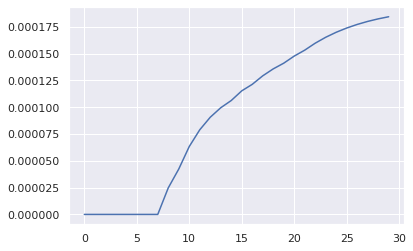

In [115]:
plt.plot(list(range(30)), mapk_ubcf)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


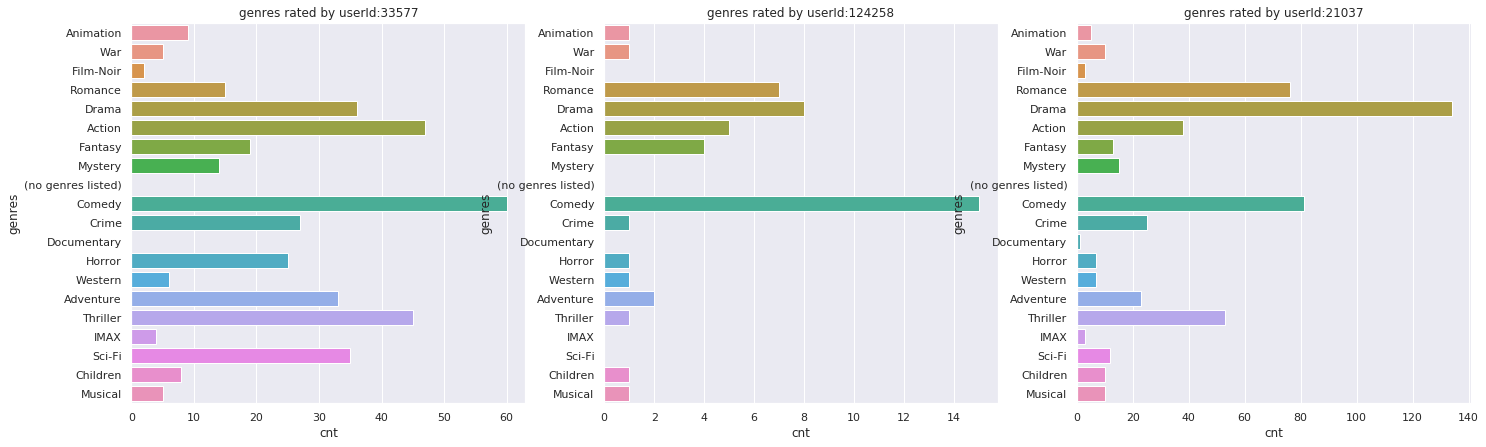

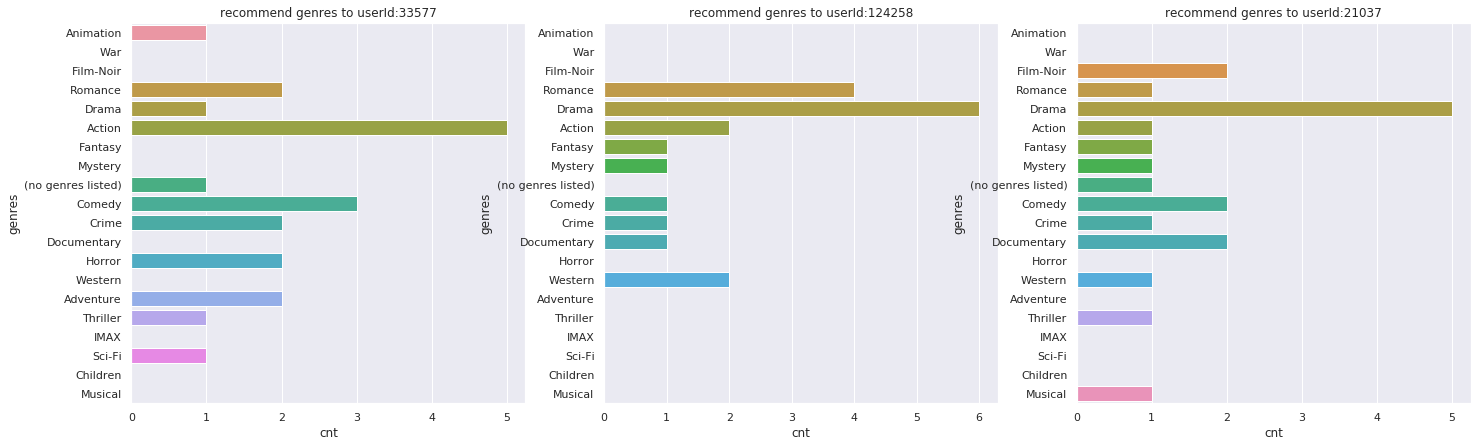

In [130]:
genre_col_name = plot_sampling_user_dist(sampling_user_id, ratings_sample, movies)
plot_recommend_dist(sampling_user_id, movies, model=ubcf, topN=10, genre_col_name=genre_col_name)

**考察**  
ユーザーが未評価のアイテムに対して評価しているユーザー数がごくわずか。そのわずかな評価値が5であることが多いために、評価値の推定が偏っている。

# item-base collaborative filtering

In [118]:
# 計算コストを抑えるためにユーザー数を絞る
ratings_sample_by_item = filter_df(ratings, col_name='movieId', N=1000)
# 検証対象のuserId
sampling_user_id_ = random.sample(list(set(ratings_sample_by_item.userId)), 3)

In [119]:
ratings_sample_by_item.head()

,userId,movieId,rating,timestamp
0,1,5147,4.0,1147877654
1,2,2987,0.5,1141417894
2,2,40815,5.0,1141416609
3,3,3527,4.0,1439474769
4,3,40815,4.0,1453904062


In [120]:
class ItemBaseCF:
    """
    item-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str):
        
        super(ItemBaseCF, self).__init__(data, user_id_name, item_id_name, rating_name)
        # user_idを縦持ちから横持ちに変換
        ratings_pivod = data.pivot_table(values=[rating_name], index=[item_id_name], columns=[user_id_name], aggfunc='sum')
        # MultiIndexを解除、item_inの特徴量カラムに変更
        user_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = user_columns
        ratings_pivod = ratings_pivod.reset_index()
        self.data = ratings_pivod[user_columns]
        self.index2itemId = self.get_index2itemId(ratings_pivod[item_id_name])
        self.userId2index = self.get_userId2index(user_columns)
        
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        
        user_index = self.userId2index[user_id]
        ratings_array = np.array(self.data)
        # 未評価のitemのindex
        non_eval_index_list = np.where(np.isnan(ratings_array.T[user_index]))[0]

        est_eval = list()
        for index in non_eval_index_list:
            # 評価したitemのindex
            eval_item_index = np.where(~np.isnan(ratings_array.T[user_index]))[0]
            # 未評価のindexに対する評価を推定
            k = np.nansum(self.sim_mat[index][eval_item_index])
            sim_vec = self.sim_mat[index][eval_item_index]
            eval_vec = ratings_array.T[user_index][eval_item_index]
            est = np.nansum(sim_vec * eval_vec) / k
            if np.isnan(est):
                est_eval.append(0)
            else:
                est_eval.append(np.nansum(sim_vec * eval_vec) / k)
        
        # 推定した評価値を代入
        ratings_array.T[user_index][non_eval_index_list] = np.array(est_eval)
        higher_index = np.argsort(ratings_array.T[user_index])[::-1]

        item_id_list = list()
        sims = list()
        for i in higher_index:
            if i in non_eval_index_list:
                item_id_list.append(self.index2itemId[i])
                sims.append(ratings_array.T[user_index][i])
                if len(item_id_list) > topN:
                    break
        
        result = [(index, similarity) for index, similarity in zip(item_id_list, sims)]
        return result
        

In [121]:
ibcf = ItemBaseCollaborativeFiltering(
    data=ratings_sample_by_item,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating')

In [ ]:
ibcf.fit()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plot_recommend_dist(sampling_user_id_, movies, model=ibcf, topN=10)
plot_sampling_user_dist(sampling_user_id_, ratings, movies)

# Model-base collaborative filtering

SVD(singular value decomposition)によって評価値行列を分解する。指定した因子を保持するユーザー行列、アイテム行列を生成する。  
https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

In [157]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

class ModelBaseCollaborativeFiltering:
    """
    user-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str, factor_num: int):
        
        def get_userId2index(user_id_series: pd.Series):
            userId2index = dict()
            for num, user_id in enumerate(user_id_series):
                userId2index[user_id] = num
            return userId2index
        
        def get_itemId2index(item_id: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(movies.movieId):
                itemId2index[item_id] = num
            return itemId2index
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        self.k = factor_num
        
        # item_idを縦持ちから横持ちに変換
        ratings_pivod = ratings_sample.pivot_table(values=['rating'], index=['userId'], columns=['movieId'], aggfunc='sum')
        # MultiIndexを解除、item_idの特徴量カラムに変更
        item_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = item_columns
        ratings_pivod = ratings_pivod.reset_index()
        self.data = ratings_pivod[item_columns]
        self.userId2index = get_userId2index(ratings_pivod[user_id_name])
        # 欠損値はアイテムごとの平均値で補完し、ユーザーごとの平均値を差し引く
        self.data_fill = self.data.fillna(self.data.mean(axis=0))
        self.data_norm = self.data_fill.sub(self.data_fill.mean(axis=1), axis=0)
        
        
    
    def fit(self):
        # 評価値行列作成
        u, s, vt = svds(self.data_norm, k=self.k)
        # 対角行列作成
        s_sqrt = np.sqrt(np.diag(s))
        # ユーザーの潜在因子行列
        u_hat = np.dot(u, s_sqrt)
        # アイテムの潜在因子行列
        v_hat = np.dot(s_sqrt, vt)
        # 評価値行列のユーザーごとの平均
        R_bar_u = np.array(self.data_fill.mean(axis=1)).reshape(-1, 1)
        # 評価値の推定
        self.est_eval = np.dot(u_hat, v_hat) + R_bar_u
    
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        
        user_index = self.userId2index[user_id]
        # 未評価のindex list
        non_eval_index_list = np.where(np.isnan(np.array(self.data)[user_index]))[0]
        
        higher = np.argsort(self.est_eval[user_index])[::-1]
        result = list()
        for i in higher:
            if i in non_eval_index_list:
                result.append((self.data.columns[i], self.est_eval[user_index][i]))
            if len(result) > topN:
                break
        return result

In [164]:
mbcf = ModelBaseCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating',
    factor_num=100)

In [165]:
mbcf.fit()

In [166]:
actuals_mbcf = [v.movieId.to_list() for i,v in test.query('rating >= 3.0').groupby('userId')]
predicted_mbcf = [[item_id for item_id, sim in mbcf.recommend(i, 30)] for i in set(test.query('rating >= 3.0').userId)]

In [167]:
mapk_mbcf = map_k(actuals_mbcf, predicted_mbcf, 30)

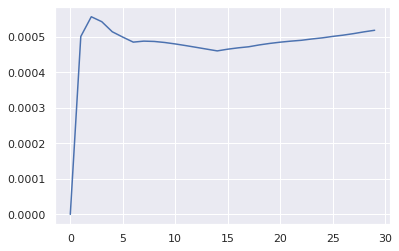

In [168]:
plt.plot(list(range(30)), mapk_mbcf)

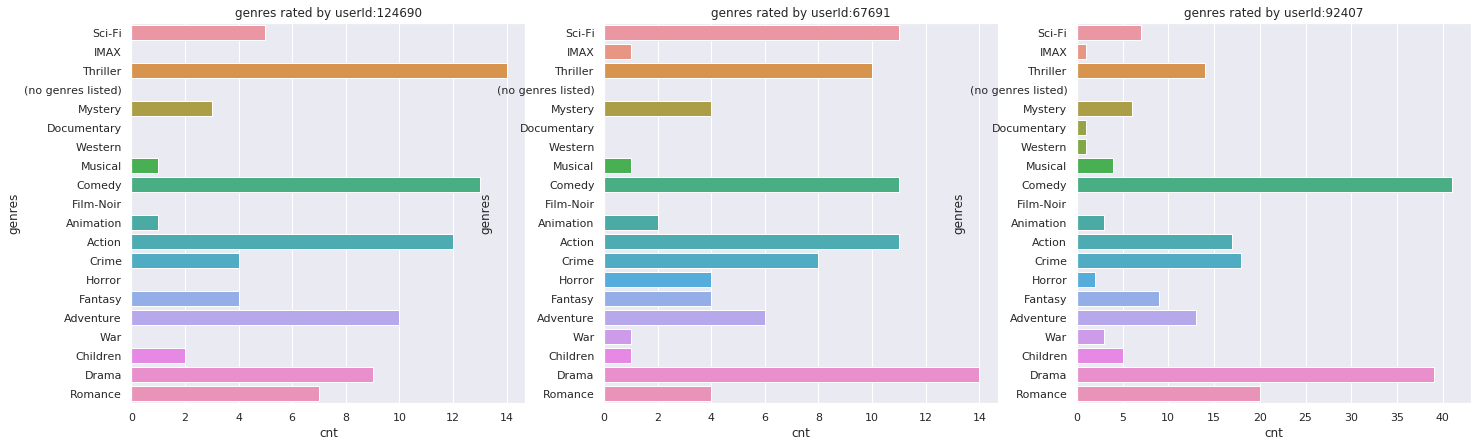

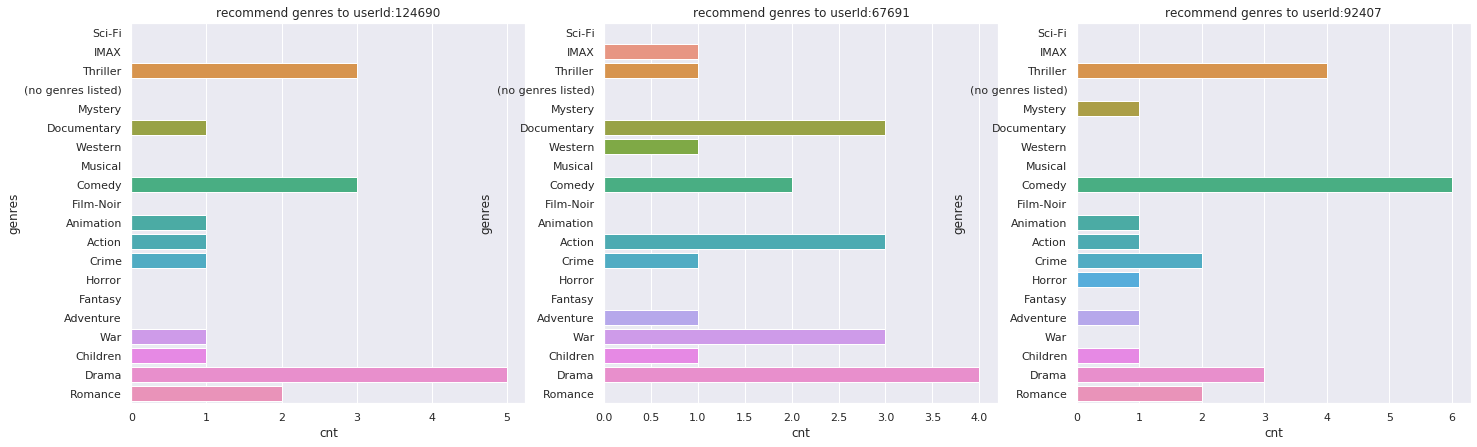

In [76]:
genre_col_name = plot_sampling_user_dist(sampling_user_id, ratings_sample, movies)
plot_recommend_dist(sampling_user_id, movies, model=mbcf, topN=10, genre_col_name=genre_col_name)

# DeepLearning

Word2Vecでレコメンドする。  
https://yolo-kiyoshi.com/2020/08/16/post-2168/

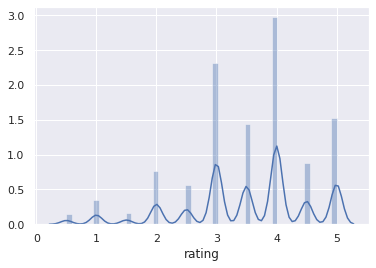

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(ratings_sample.rating)

In [135]:
from gensim.models import Word2Vec

class NNCollaborativeFiltering:
    """
    DeepLearning base colaborative filteringを実装したクラス
    """
    def __init__(
        self, data, user_id_name: str, item_id_name: str,
        rating_name: str, date_col_name: str, geq: float):
        
        def get_userId2itemList(data: pd.DataFrame, user_id_name: str, item_id_name: str):
            userId2itemList = dict()
            for i, v in data.groupby(user_id_name):
                userId2itemList[i] = v[item_id_name].to_list()
            return userId2itemList
        
        # ユーザーごとにtimestampで昇順ソート
        data.sort_values([user_id_name, date_col_name], inplace=True)
        # item_idのデータ型をstr型に変換
        data.loc[:, item_id_name] = data[item_id_name].astype('str')
        # 評価値が一定数以上のデータのみに絞り込む
        data_filtered = data.query(f'{rating_name} >= {geq}')
        self.data_filtered = data_filtered
        # 学習データ作成
        self.train = [v[item_id_name].to_list() for i,v in data_filtered.groupby('userId')]
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        self.userId2itemList = get_userId2itemList(data, user_id_name, item_id_name)
        
    
    def fit(self):
        self.model = Word2Vec(self.train)
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        def get_word2index_dict(model):
            """
            wordからindexを取得できる辞書を作成する
            """
            word2index = dict()
            for i in range(len(model.wv.vocab)):
                word2index[model.wv.index2word[i]] = i
            return word2index


        def customized_most_similar(model, positive: list, remove_index: list, word2index: dict, topN: int):
            """
            特定のwordを除外してmost_similarを出力する

            Parameters
            ----------
            model : gensim.model.Word2Vec
                word2vec学習済みモデル。
            positive : list
                加算対象のwordのlist。
            remove_index : list
                除外対象のwordのindexのlist。
            word2index : dict
                wordがkey、indexがvalueのdict。
            topN : int
                出力対象のword数。

            Returns
            -------
            result : list
                類似度topNの(word, sim)のtupleのlist。
            """

            model.wv.init_sims()
            # 加算対象のwordのベクトルを取得し、合成する
            pos = [model.wv.vectors_norm[word2index[i]] for i in positive]
            pos_sum = np.sum(np.array(pos), axis=0)
            # cosine類似度ベクトルを作成
            sim = np.dot(model.wv.vectors_norm, pos_sum)/np.linalg.norm(pos_sum)
            # 加算対象のwordを除外wordに追加
            positive_index = [word2index[i] for i in positive]
            remove_index = remove_index + positive_index
            # cosine類似度ベクトルから除外対象のwordを除外
            sim = np.delete(sim, remove_index, 0)
            # index2wordからも除外対象のwordを除外
            index2word = np.delete(np.array(model.wv.index2word), remove_index, 0)
            # 類似度topNを取得
            topn = np.argsort(sim)[::-1][:topN]

            return [(index2word[i], sim[i]) for i in topn]
        
        # word2index作成
        word2index = get_word2index_dict(self.model)
        
        # 評価済みのindex
        eval_index_set = set(self.userId2itemList[user_id])
        # 学習済みモデルのvocabに存在する
        vocab_in_model = list(self.model.wv.vocab.keys())
        eval_index_list = list(eval_index_set & set(vocab_in_model))
        
        remove_index = [word2index[i] for i in eval_index_list]
        # 直近の高評価かつモデルに存在するmovie
        trigger = self.data_filtered.query(
            f'({self.user_id_name} == "{user_id}") & ({self.item_id_name} in @vocab_in_model)'
        )[self.item_id_name][-1:].to_list()
        
        return customized_most_similar(
            model=self.model,
            positive=trigger,
            remove_index=remove_index,
            word2index=word2index,
            topN=topN
        )
        

In [136]:
nncf = NNCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating',
    date_col_name='timestamp',
    geq=3.0)

In [137]:
nncf.fit()

In [138]:
vocab_in_model = list(nncf.model.wv.vocab.keys())

In [139]:
actuals_nncf = [v.movieId.to_list() for i,v in test.query('(rating >= 3.0) & (movieId in @vocab_in_model)').groupby('userId')]
predicted_nncf = [[item_id for item_id, sim in nncf.recommend(i, 30)] for i in set(test.query('(rating >= 3.0) & (movieId in @vocab_in_model)').userId)]

In [140]:
mapk_nncf = map_k(actuals_nncf, predicted_nncf, 30)

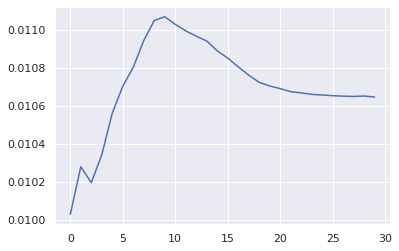

In [141]:
plt.plot(list(range(30)), mapk_nncf)

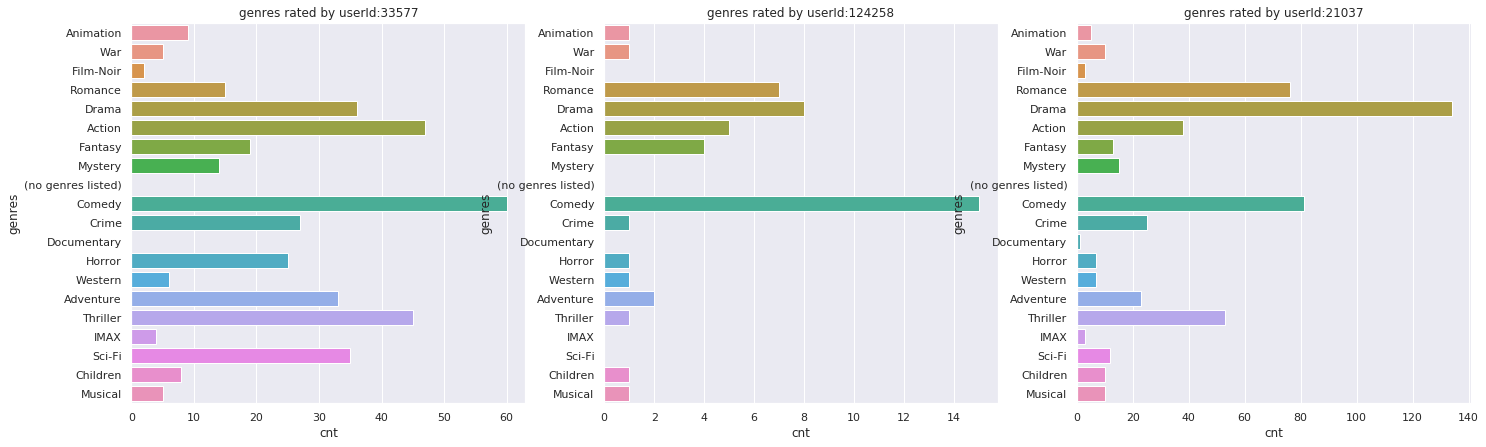

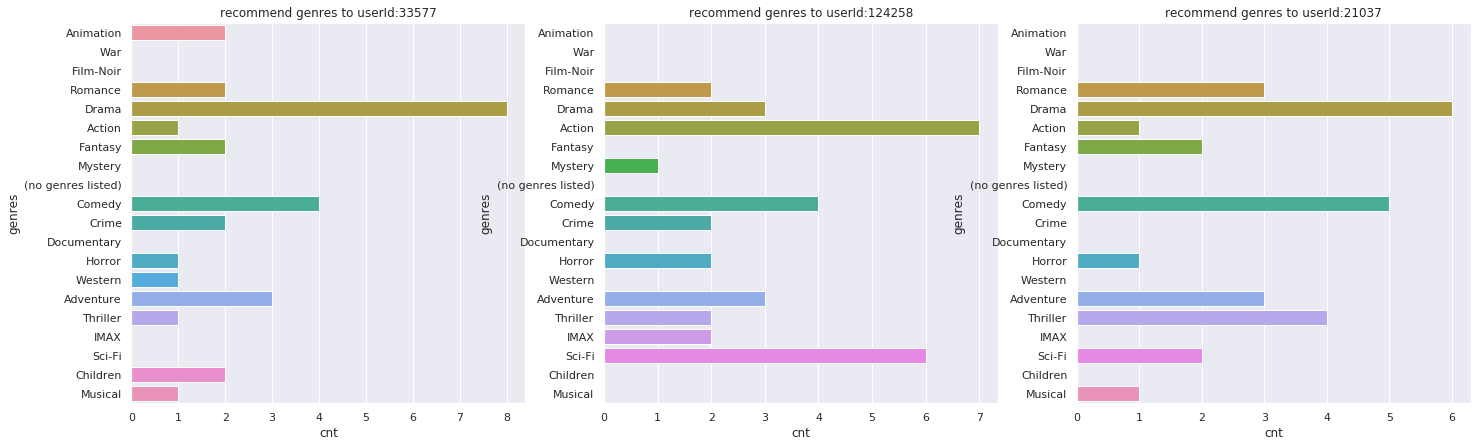

In [145]:
genre_col_name = plot_sampling_user_dist(sampling_user_id, ratings_sample, movies)
plot_recommend_dist(sampling_user_id, movies, model=nncf, topN=10, genre_col_name=genre_col_name)

# evaluate Models

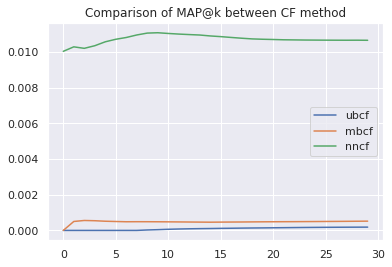

In [169]:
plt.plot(list(range(30)), mapk_ubcf, label='ubcf')
plt.plot(list(range(30)), mapk_mbcf, label='mbcf')
plt.plot(list(range(30)), mapk_nncf, label='nncf')
plt.title('Comparison of MAP@k between CF method')
plt.legend()